# Notes
* original dataset: https://www.kaggle.com/competitions/fake-news/data


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from timeit import default_timer as timer
from datetime import timedelta

In [9]:
input_path = "./data/"
output_path = "./models/"

submit = pd.read_csv(input_path + "submit.csv") # sample labels; I think it's just to show format of output for test predictions
test = pd.read_csv(input_path + "test.csv")
train = pd.read_csv(input_path + "train.csv")

# labels

## Data preprocessing

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# only run to download resources; can specify download directory with argument `download_dir`
# import nltk
# nltk.download("wordnet")
# nltk.download("stopwords")

In [4]:
def clean_text(df, text):
    # basic error handling
    df = df.drop_duplicates()
    df = df.dropna(subset=[text])
    
    # elminating weird characters
    df[text] = df[text].str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)
    df[text] = df[text].str.lower()
    df = df.dropna(subset=[text])
    
    tokens = df[text].str.split()
    
    # stop words: TODO
    sw = stopwords.words("english")
    
    tokens = tokens.apply(lambda row_words: [word for word in row_words if sw.count(word)==0])
    
    # stemming/lemmatizing
#     stemmer = PorterStemmer()
#     tokens = tokens.apply(lambda row_words: [stemmer.stem(word) for word in row_words])
    lemmatizer = WordNetLemmatizer()
    tokens = tokens.apply(lambda row_words: [lemmatizer.lemmatize(word) for word in row_words])
    
    tokens = tokens.apply(lambda row_words: ' '.join(row_words))

    
    df[text] = tokens
    return df

In [5]:
train_clean = clean_text(train, "text")

In [6]:
train_clean.text.head(10)

0    house dem aide even see comey letter jason cha...
1    ever get feeling life circle roundabout rather...
2    truth might get fired october 29 2016 tension ...
3    video 15 civilian killed single u airstrike id...
4    print iranian woman sentenced six year prison ...
5    trying time jackie mason voice reason week exc...
6    ever wonder britain iconic pop pianist get lon...
7    paris france chose idealistic traditional cand...
8    donald j trump scheduled make highly anticipat...
9    week michael flynn resigned national security ...
Name: text, dtype: object

Turned cells below into raw because I already trained a model, and it took a while, so I just stored it and will load it later.

If I already have above things trained, I can just load them as in below (and **don't** fit, just transform):

In [59]:
tfidf = pickle.load(open(output_path + "tfidf_vectorizer.pkl", "rb"))

tfidf_sparse = tfidf.transform(train_clean["text"])

In [60]:
truncsvd_5000 = pickle.load(open(output_path + "truncsvd_5000.pkl", "rb"))
dim_reduced = truncsvd_5000.transform(tfidf_sparse)


In [43]:
truncsvd_5000.explained_variance_ratio_.sum() # a little low, but I think that more components is infeasible

0.7732754557272887

## Word Cloud to view contents

In [262]:
from wordcloud import WordCloud



real_text = train_clean.loc[train_clean.label==0, "text"]
real_text = " ".join([article for article in real_text.astype(str)])

fake_text = train_clean.loc[train_clean.label==1, "text"]
fake_text = " ".join([article for article in fake_text.astype(str)])

Word Cloud of Real Articles

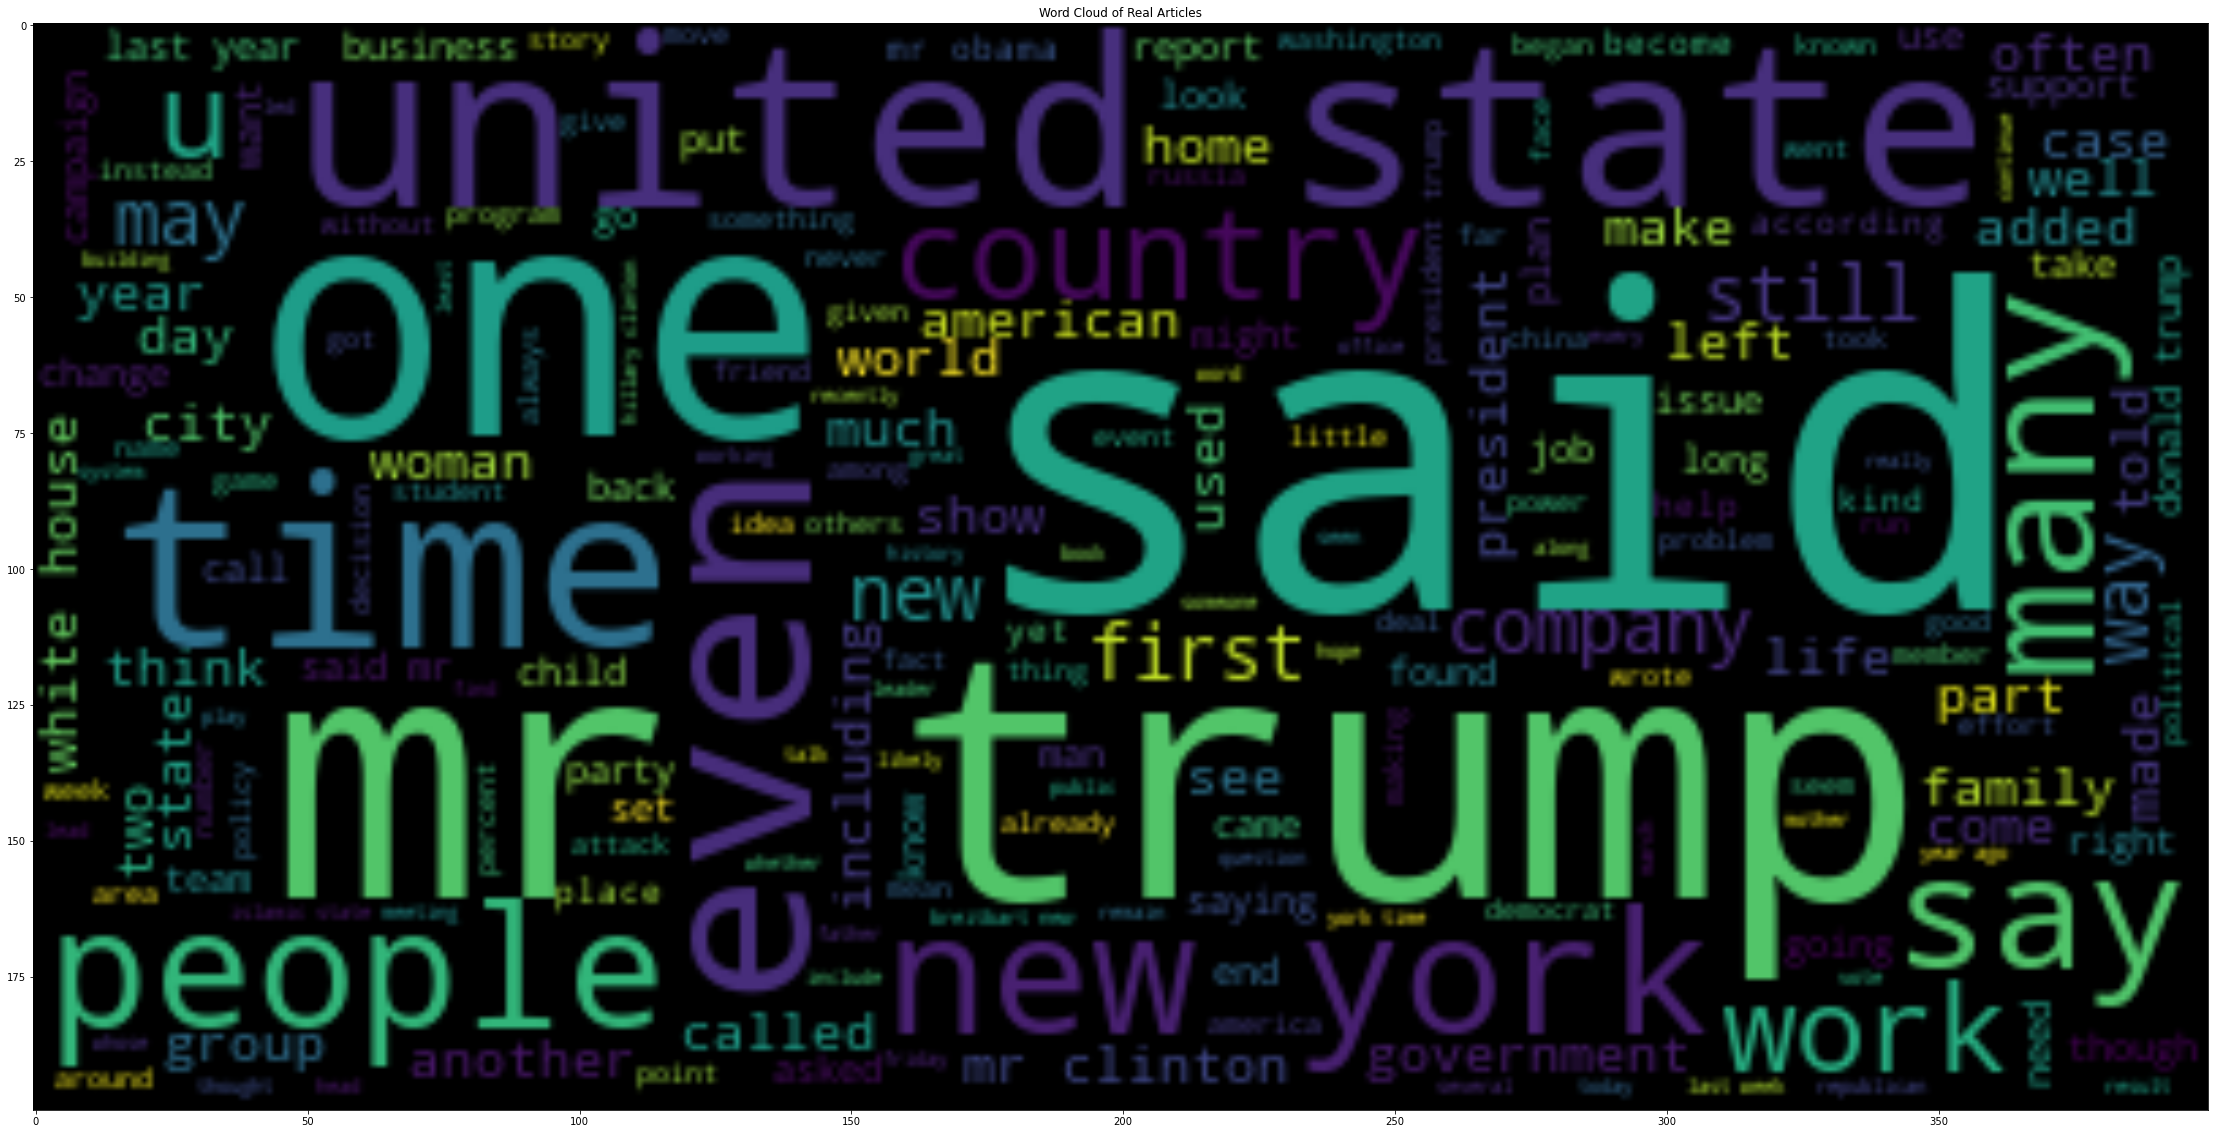

In [264]:
real_wc = WordCloud().generate(real_text)
plt.figure(figsize=(40, 20))
plt.tight_layout(pad=0)
plt.imshow(real_wc, interpolation='bilinear')
plt.title("Word Cloud of Real Articles")
plt.show()

Word Cloud of Fake Articles

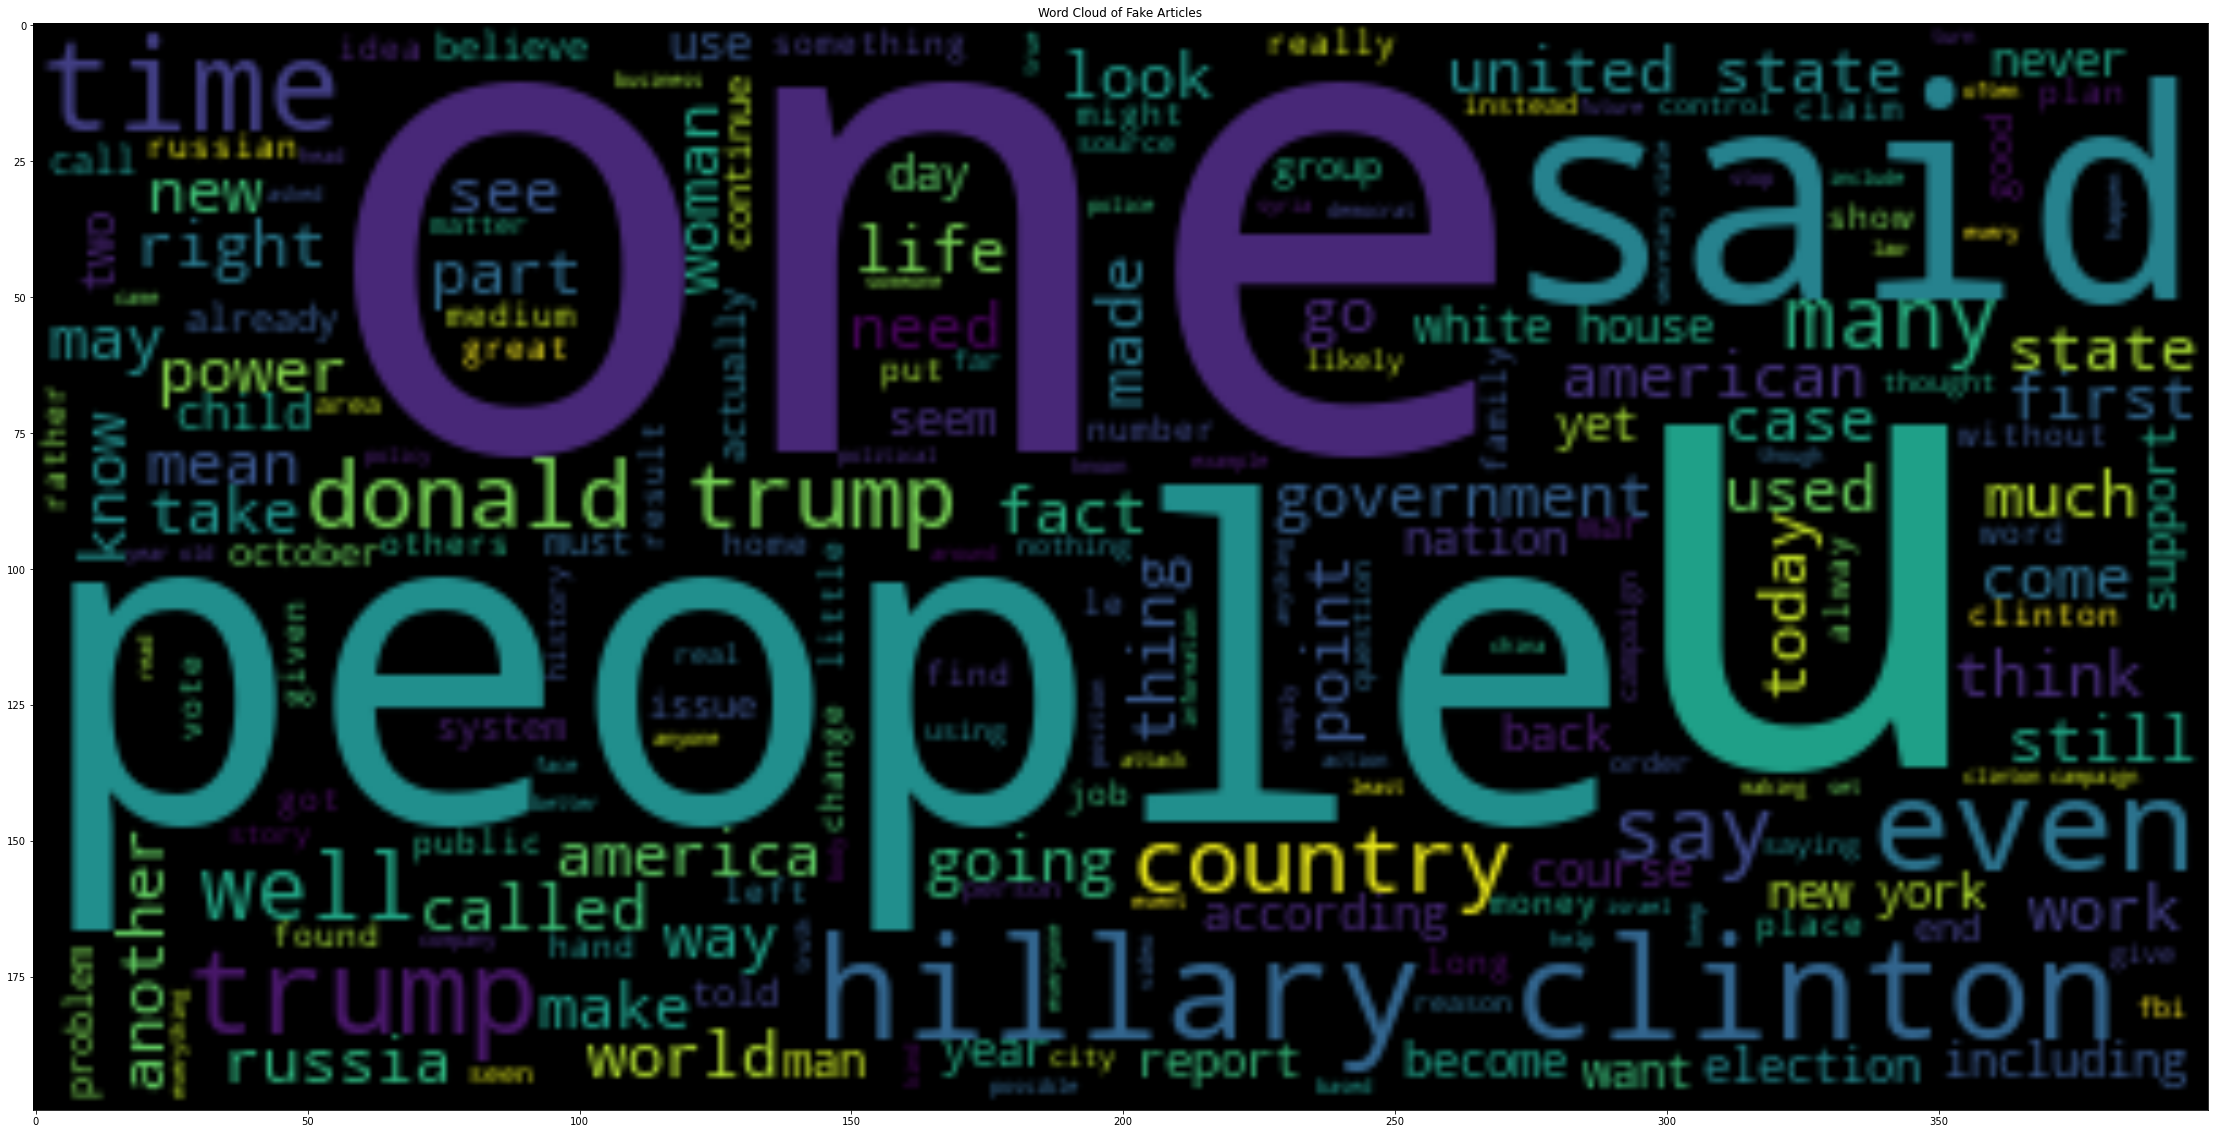

In [265]:
fake_wc = WordCloud().generate(fake_text)
plt.figure(figsize=(40, 20))
plt.tight_layout(pad=0)
plt.imshow(fake_wc, interpolation='bilinear')
plt.title("Word Cloud of Fake Articles")
plt.show()

## Model training and selection

I'm realizing that I did TF-IDF Vecorization and PCA before splitting, which maybe I need to rethink. I'll do that later

In [70]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

X = dim_reduced # should try both tfidf vector representation and a dimensionality reduced one
y = train_clean.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42, stratify=y)

The gridsearch below took over an hour to run, and turns out having more estimators past 10 didn't do anything but was likely responsible for length. Also, not setting a max_depth defaults to a max_depth of 6, even if the literal parameter will say None. I didn't know that prior, and turns out a max_depth of 6 performs better than 100 does anyway.

EDIT: I later tested 10 vs 100 estimators on hold-out from train.csv, and 100 estimators performed better.

Loading trained xgboost ensemble

In [151]:
xgb_best = pickle.load(open(output_path + "xgb_100_estimators.pkl", "rb"))

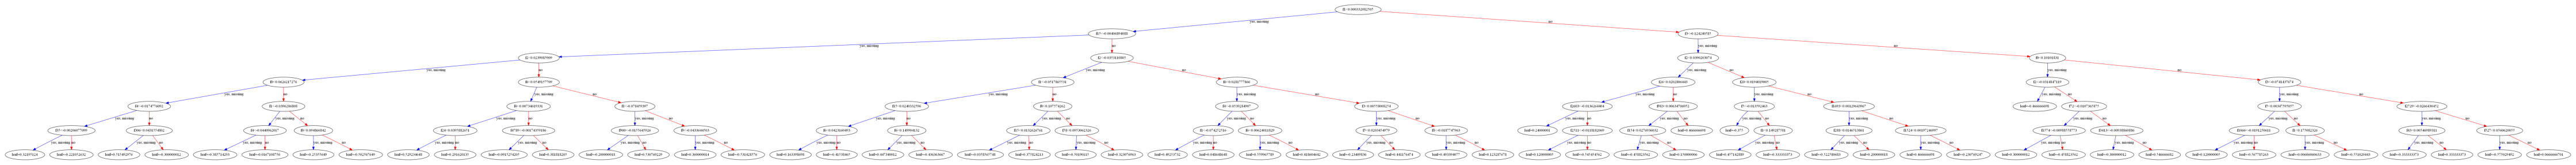

In [152]:
# a bit too small to see, but this is what the first tree looks like; also, here the features are the principle components
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50
from xgboost import plot_tree

plot_tree(xgb_best)
plt.show()

In [142]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

y_pred = xgb_best.predict(X_test)

print("Accuracy on hold-out of train.csv:", accuracy_score(y_test, y_pred))
metrics = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1], pos_label=1)
metrics = pd.DataFrame(metrics)
metrics.columns = ["Class 0 (real)", "Class 1 (fake)"]
metrics.index = ["Precision", "Recall", "F-1 score", "Support"]

metrics["Avg., weighted by support"] = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1], pos_label=1, average="weighted")

metrics.head()

Accuracy on hold-out of train.csv: 0.9272814832651095


,Class 0 (real),Class 1 (fake),"Avg., weighted by support"
Precision,0.926923,0.927641,0.927282
Recall,0.927815,0.926747,0.927281
F-1 score,0.927369,0.927194,0.927281
Support,2078.000000,2075.000000,None


## Trying this again, but splitting before the other stuff

I'm guessing this is the real approach. The thing is though, these final models will have been trained on fewer data points when it comes to actually using them to predict labels for the unlabled test.csv. So idk if I should be using these for model selection (in terms of the parameters), and then retain them on the whole train.csv instead of just 80\% of it?

I'll reassign variables from earlier, but I'll save these new models in a new output path so as not overwrite what's already been trained in case that is correct instead.

In [266]:
new_output="./models_test/"

X = train_clean.text
y = train_clean.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

Ran cell below once and then turned into raw

In [269]:
tfidf = pickle.load(open(new_output + "tfidf_vectorizer.pkl", "rb"))
X_train_tfidf = tfidf.transform(X_train)

Ran cell below once and then turned into raw

In [272]:
truncsvd = pickle.load(open(new_output + "truncsvd_5000.pkl", "rb"))
X_train_dimreduced = truncsvd.transform(X_train_tfidf)

**TODO:**
* Still need to train a new xgboost with this newly prepared X_train set(s) (both the tfidf and dim_reduced)
* want to play around with xgboost's xgb.train and DMatrix's because the XGBClassifier I'm using is just the sklearn wrapper
* Want to make a pipeline that I can just feed test data into
* Try to make submission csv's using both sets of models
* fix this stupid ass packed object push error

* Taha has a few other suggestions
    * basically put everything in a pipeline, it should take care of my question and confusion lol. i should compare pipeline scoring output with scores I already have to better understand what it's doing 
    * transformers, specifically huggingface -> just pass data through, and it'll produce embeddings
    * a bit about embeddings
        * formed with artificual neural networks
        * remove output layer, add two inner layers: an encoder and then decoder, they're both fully connected
        * usually input layer isn't fully connected to first encoder inner layer, 
        * output is n-dimensional where n is how many nodes in decoder layer
        * maybe truncate to first 500 words before doing this
    * can use pre-trained models like BERT, gp3 something by Deepmind
    * use examples here: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens, and https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
    * consider also using sentence-level instead of word-level
    * he's also mentioning topioc modeling
        * bunch of text, want to extract groups of topics in corpus
            * use this: https://github.com/MaartenGr/BERTopic

* end product could be like a SaaS application where someone can input a news article and predict whether article is fake news
* streamlit or plotly or flask for frontend
    * in flask, create a file as a server